### Exploratory Analysis

The main idea is to apply some quantitative trading to the Crypto-sphere and to see if we can create some trading strategies with decent $\alpha$. In the future, it may be possible to run the mutual fund using both algorithmic trading and manual trading (via. Will's domain knowledge).

In order to start algorithmically trading, we need to first decide which currencies that we are willing to trade. We will also need to create a market index to use as the baseline for measuring how well a strategy is actually performing. 


#### Data Collection and Compression

Data is collected from the CoinMarketCap API. 


In [1]:
%matplotlib inline

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

N_COINS = 30

df = pd.read_json(f'https://api.coinmarketcap.com/v1/ticker/?limit={N_COINS}')
df = df.infer_objects()
df.head()


,24h_volume_usd,available_supply,id,last_updated,market_cap_usd,max_supply,name,percent_change_1h,percent_change_24h,percent_change_7d,price_btc,price_usd,rank,symbol,total_supply
0,8029010000,16829437,bitcoin,1517053760,185260125440,2.100000e+07,Bitcoin,-2.34,3.75,-13.59,1.000000,11008.100000,1,BTC,16829437
1,2996370000,97240758,ethereum,1517053753,102833074520,NaN,Ethereum,-1.80,4.06,-6.46,0.096535,1057.510000,2,ETH,97240758
2,1222230000,38739142811,ripple,1517053741,46154589528,1.000000e+11,Ripple,-2.00,0.49,-24.53,0.000109,1.191420,3,XRP,99993093880
3,459866000,16934488,bitcoin-cash,1517053757,26640658356,2.100000e+07,Bitcoin Cash,-2.32,3.42,-17.20,0.143607,1573.160000,4,BCH,16934488
4,636317000,25927070538,cardano,1517053760,15534515438,4.500000e+10,Cardano,-2.28,3.89,-14.00,0.000055,0.599162,5,ADA,31112483745


We we want to compress this data by removing irrelevant and/or redundant features. This will allow us to minimize our disk usage (which will be useful for future scalability), and allow us to present our information in a more useful and human-readable format.

1. Remove `name` and `id`. Instead, use `symbol`.
2. Remove `max_supply`, `total_supply`, and `available_supply`. The max supply of BTC will always be 2.1e7. We don't need to store it again every 5 minutes. Total and available supply are both irrelvant.
3. Remove `price_btc`. It is a redundant field that can be easily re-calculated with `price_usd`.
4. Reorder remaining fields to a more human-readable format.

This is my proposed improvement:

In [2]:
df = pd.read_json(f'https://api.coinmarketcap.com/v1/ticker/?limit={N_COINS}')
df = df.infer_objects()

df = df[['rank', 'symbol', 'price_usd', 'market_cap_usd', '24h_volume_usd',
         'percent_change_1h', 'percent_change_24h', 'percent_change_7d']]

df.head()

,rank,symbol,price_usd,market_cap_usd,24h_volume_usd,percent_change_1h,percent_change_24h,percent_change_7d
0,1,BTC,11008.100000,185260125440,8029010000,-2.34,3.75,-13.59
1,2,ETH,1057.510000,102833074520,2996370000,-1.80,4.06,-6.46
2,3,XRP,1.191420,46154589528,1222230000,-2.00,0.49,-24.53
3,4,BCH,1573.160000,26640658356,459866000,-2.32,3.42,-17.20
4,5,ADA,0.599162,15534515438,636317000,-2.28,3.89,-14.00


We will make serial calls to this API every 5 minutes, and store results in their own time-stamped CSV.

###### Global Data

The API also provides access to global data.

In [3]:
json = requests.get('https://api.coinmarketcap.com/v1/global/').json()
global_df = pd.DataFrame([json]).infer_objects()

print(global_df.head())

   active_assets  active_currencies  active_markets  \
0            567                896            8165   

   bitcoin_percentage_of_market_cap  last_updated  total_24h_volume_usd  \
0                             34.45    1517053760          2.338388e+10   

   total_market_cap_usd  
0          5.378251e+11  


Since we would only be adding one line of data with each API call, data compression is not as much of an issue for this data. 

We will make serial calls to this API every 5 minutes, and save each record's data into its own row separated by date. The timestamp of the call will be saved as an additional field.

#### Establishing a Market Index

From [Investopedia](https://www.investopedia.com/terms/m/marketindex.asp#ixzz555QvCO80):

`
A market index is an aggregate value produced by combining several stocks or other investment vehicles together and expressing their total values against a base value from a specific date. Market indexes are intended to represent an entire stock market and thus track the market's changes over time. 
`

We will choose coins for the index scaled by their respective market caps; this approach allows us to get a good measurement for the coin markets while keeping the total number of coins in our portfolio small.

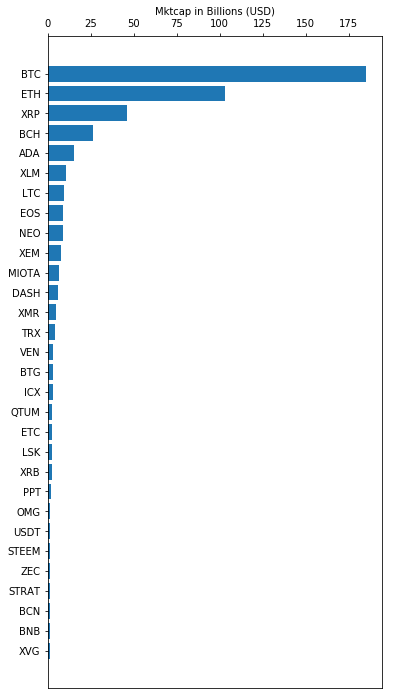

In [4]:
fig, ax = plt.subplots(figsize=(6, 12))

ax.barh(df['rank'], df['market_cap_usd']/10**9)
ax.invert_yaxis()
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

ax.set_xlabel('Mktcap in Billions (USD)')
plt.setp(ax, yticks=np.arange(1, N_COINS+1), yticklabels=df['symbol'])

#ax.set_xticklabels(df["symbol"])

plt.show()


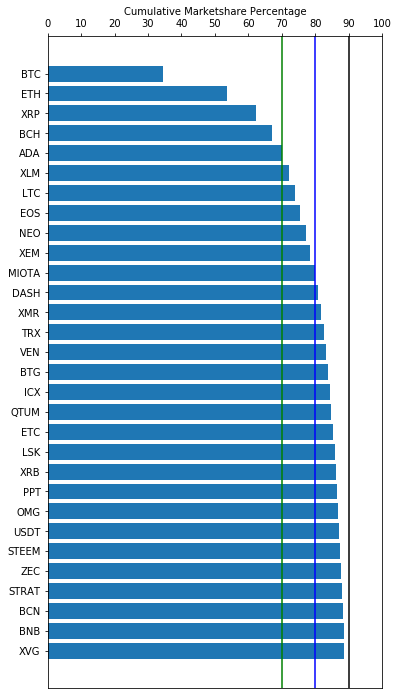

0     34.446165
1     53.566335
2     62.148045
3     67.101450
4     69.989846
5     72.024220
6     73.819418
7     75.461889
8     77.097993
9     78.497971
10    79.727409
11    80.836600
12    81.742337
13    82.560167
14    83.149015
15    83.706342
16    84.248599
17    84.773947
18    85.295834
19    85.765684
20    86.210709
21    86.572848
22    86.874747
23    87.175444
24    87.444501
25    87.705998
26    87.962630
27    88.204447
28    88.443259
29    88.674882
Name: market_cap_usd, dtype: float64


In [5]:
total_mkt_cap = global_df['total_market_cap_usd'][0]

fig, ax = plt.subplots(figsize=(6, 12))
ax.barh(df['rank'], 100*df['market_cap_usd'].cumsum()/total_mkt_cap)
ax.invert_yaxis()
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

ax.set_xlabel('Cumulative Marketshare Percentage')
plt.setp(ax, yticks=np.arange(1, N_COINS+1), yticklabels=df['symbol'])

plt.axvline(x=70, color="green")
plt.axvline(x=80, color="blue")
plt.axvline(x=90, color="black")
plt.xticks(np.arange(0, 101, 10))

plt.show()

mktcap_cumsum = 100*df['market_cap_usd'].cumsum()/total_mkt_cap
print(mktcap_cumsum)

By adjusting the `N_COINS` variable, we can see that the top 100 coins makes up approximately 95% of the market cap, while the top 5, 10, and 35 make up 70%, 80%, and 90% respectively. 


In [7]:
def top_n_perc(n):
    """
    Return the relative composition of the `top_n_perc` index as a dictionary.
    """
    ct = len([i for i in mktcap_cumsum if i < n])
    return {df['symbol'][i]: df['market_cap_usd'][i] for i in range(ct)}

print(top_n_perc(70))
print(top_n_perc(80))

{'BTC': 185260125440, 'ETH': 102833074520, 'XRP': 46154589528, 'BCH': 26640658356, 'ADA': 15534515438}
{'BTC': 185260125440, 'ETH': 102833074520, 'XRP': 46154589528, 'BCH': 26640658356, 'ADA': 15534515438, 'XLM': 10941377535, 'LTC': 9655024879, 'EOS': 8833621692, 'NEO': 8799375000, 'XEM': 7529435999, 'MIOTA': 6612224590}
